In [1]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [2]:
!ls track

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install opencv-python

  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install imgaug

  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
  Using cached Shapely-1.8.2-cp39-cp39-win_amd64.whl (1.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [7]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', None)
data.tail()

center  \
4048  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_16_31_474.jpg   
4049  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_16_31_544.jpg   
4050  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_16_31_617.jpg   
4051  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_16_31_685.jpg   
4052  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_16_32_161.jpg   

                                                                      left  \
4048  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_16_31_474.jpg   
4049  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_16_31_544.jpg   
4050  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_16_31_617.jpg   
4051  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_16_31_685.jpg   
4052  C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_16_32_161.jpg   

                                                                      right  \
4048  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_16_31_474.jpg   
4049  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_16_31_544.jpg   
4050  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_16_31_617.jpg   
4051  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_16_31_685.jpg   
4052  C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_16_32_161.jpg   

      steering  throttle  reverse     speed  
4048       0.0       0.0      0.0  26.01768  
4049       0.0       0.0      0.0  25.80864  
4050       0.0       0.0      0.0  25.65296  
4051       0.0       0.0      0.0  25.44685  
4052       0.0       0.0      0.0  17.00781

In [8]:
def pathLeaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(pathLeaf)
data['left'] = data['left'].apply(pathLeaf)
data['right'] = data['right'].apply(pathLeaf)

In [9]:
data.head()

center                              left  \
0  center_2018_07_16_17_11_43_382.jpg  left_2018_07_16_17_11_43_382.jpg   
1  center_2018_07_16_17_11_43_670.jpg  left_2018_07_16_17_11_43_670.jpg   
2  center_2018_07_16_17_11_43_724.jpg  left_2018_07_16_17_11_43_724.jpg   
3  center_2018_07_16_17_11_43_792.jpg  left_2018_07_16_17_11_43_792.jpg   
4  center_2018_07_16_17_11_43_860.jpg  left_2018_07_16_17_11_43_860.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2018_07_16_17_11_43_382.jpg       0.0       0.0      0.0  0.649786  
1  right_2018_07_16_17_11_43_670.jpg       0.0       0.0      0.0  0.627942  
2  right_2018_07_16_17_11_43_724.jpg       0.0       0.0      0.0  0.622910  
3  right_2018_07_16_17_11_43_792.jpg       0.0       0.0      0.0  0.619162  
4  right_2018_07_16_17_11_43_860.jpg       0.0       0.0      0.0  0.615438

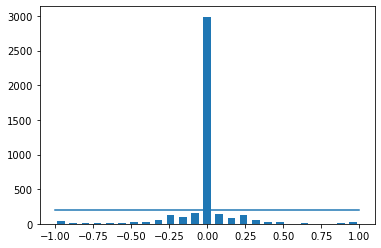

In [10]:
num_bins = 25
samples_perbin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_perbin, samples_perbin))

total data: 4053
removed: 2790
remaining: 1263


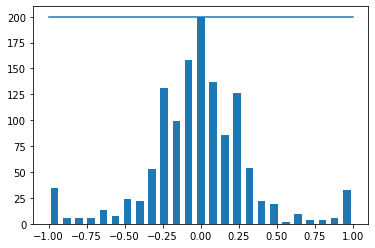

In [11]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_perbin:]
    remove_list.extend(list_)
        
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_perbin, samples_perbin))

In [12]:
print(data.iloc[5])
def load_img_steering(df, datadir):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

center      center_2018_07_16_17_11_44_697.jpg
left          left_2018_07_16_17_11_44_697.jpg
right        right_2018_07_16_17_11_44_697.jpg
steering                             -0.431962
throttle                                   1.0
reverse                                    0.0
speed                                 4.489107
Name: 16, dtype: object


In [13]:
t = datadir + '/IMG'
image_paths, steerings = load_img_steering(data, t)

In [14]:
x_train, x_val, y_train, y_val = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
# print(type(y_train))
print('training sample: {}\nValid Samples: {}'.format(len(x_train), len(x_val)))

training sample: 1010
Valid Samples: 253


Text(0.5, 1.0, 'ValidationSet')

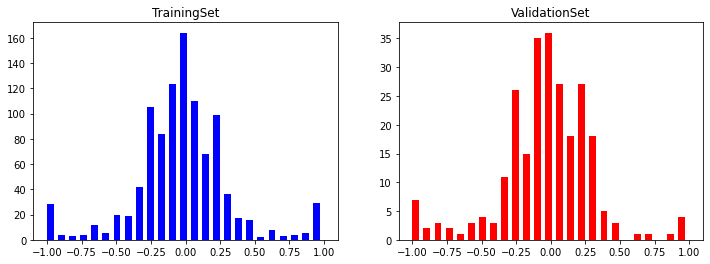

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('TrainingSet')
axes[1].hist(y_val, bins=num_bins, width=0.05, color='red')
axes[1].set_title('ValidationSet')

In [16]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'ZoomImg')

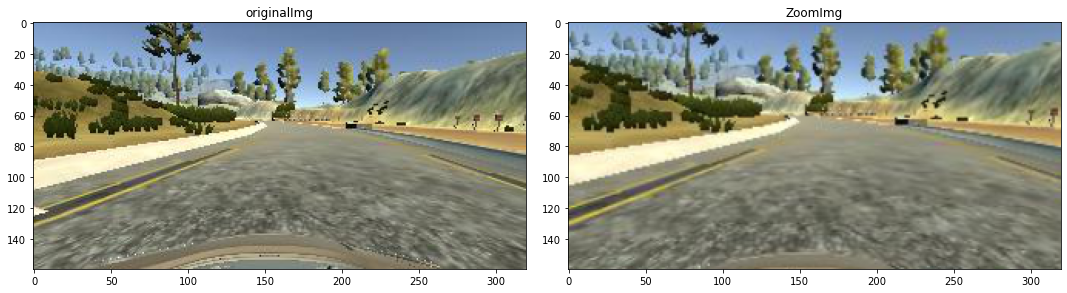

In [17]:
image= image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomedImage = zoom(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title('originalImg')

axes[1].imshow(zoomedImage)
axes[1].set_title('ZoomImg')

In [18]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

In [19]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

Text(0.5, 1.0, 'Panned Image')

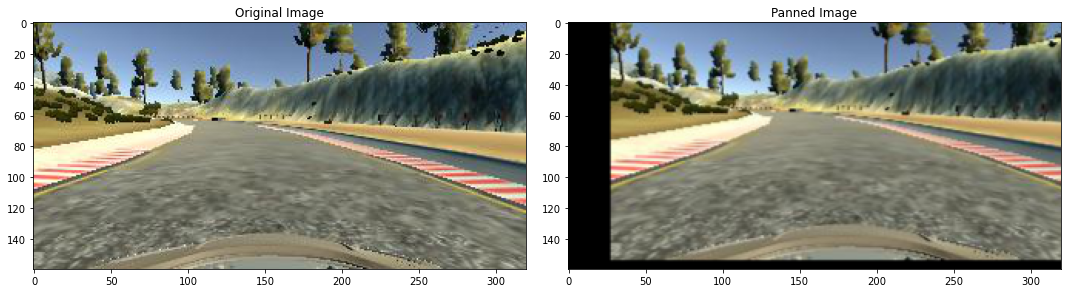

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [21]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

In [22]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

Text(0.5, 1.0, 'Brightness altered image ')

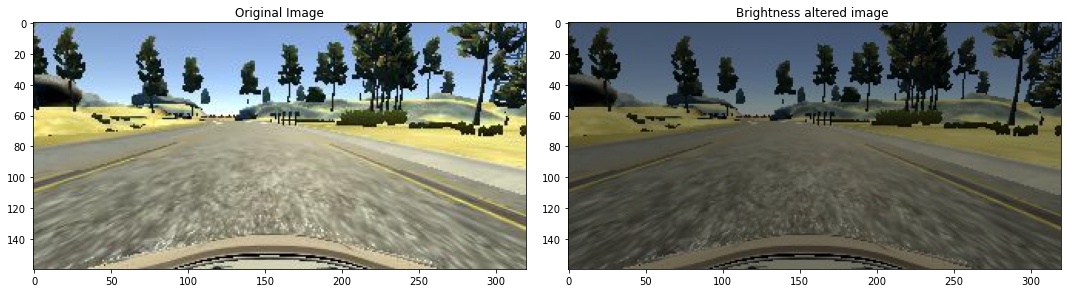

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')


In [24]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

In [25]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.1844934')

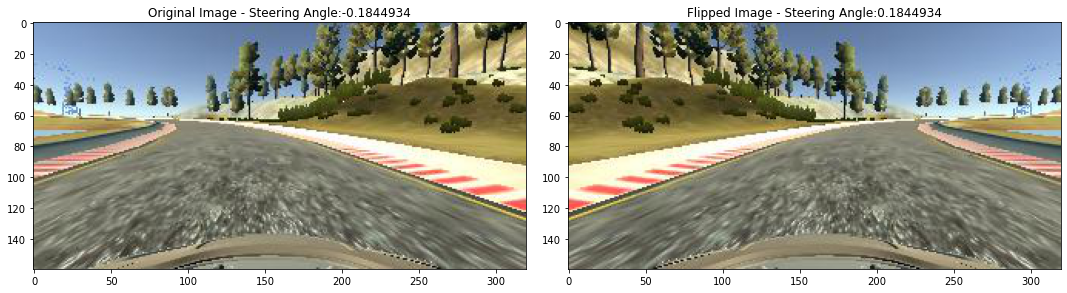

In [26]:
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [27]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
#     im = Image.fromarray(resizelis11t[val])
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

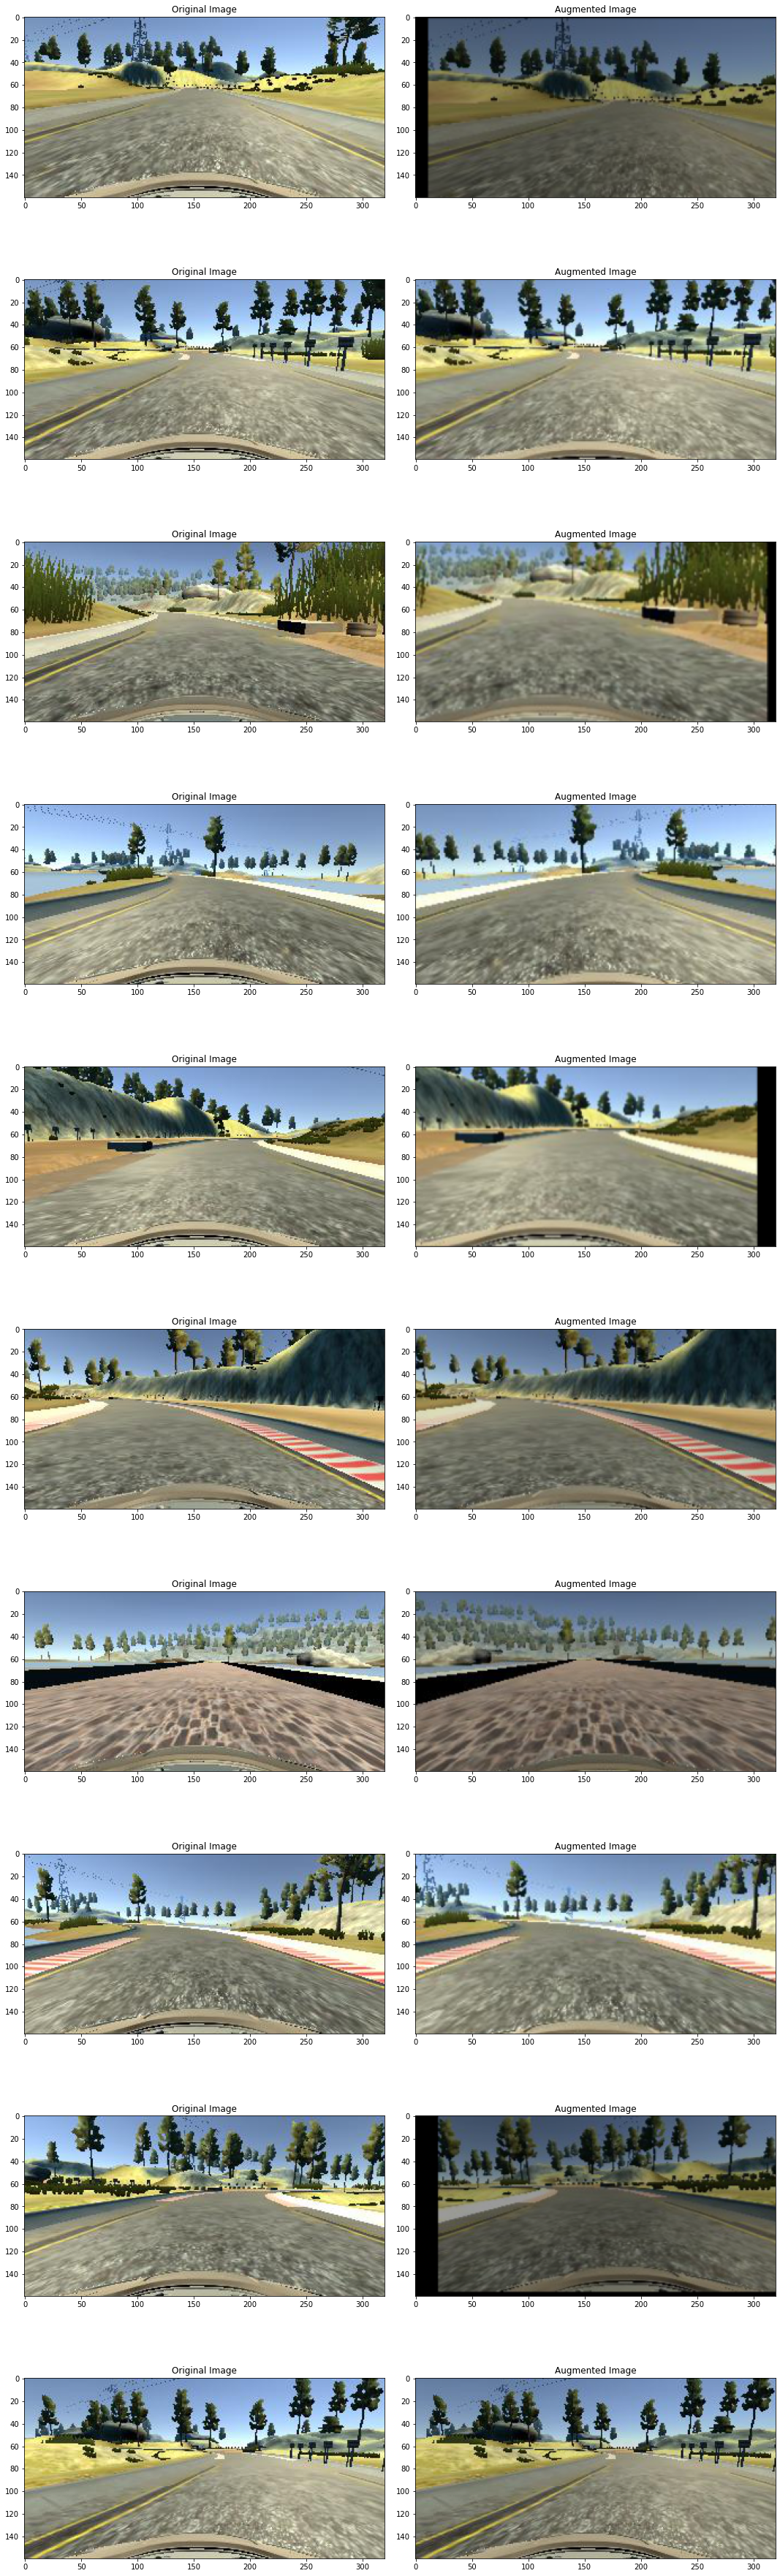

In [28]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [29]:
def img_preprocess(img):
    img = mpimg.imread(img)
    img = img[60:140, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img

Text(0.5, 1.0, 'Pre Processed Image')

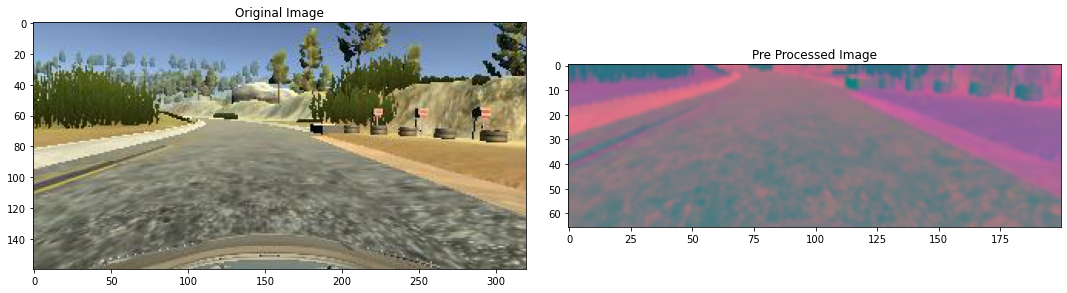

In [30]:
image = image_paths[450]
orgImg = mpimg.imread(image)
preprocessed_img = (img_preprocess(image))

fig, axs = plt.subplots(1, 2, figsize=(15, 20))
fig.tight_layout()
axs[0].imshow(orgImg)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_img)
axs[1].set_title('Pre Processed Image')

In [31]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

In [32]:
x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(x_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Train img')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Val img')

AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [ ]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, 3, 3, activation='elu'))
    model.add(Convolution2D(48, 3, 3, activation='elu'))
    model.add(Convolution2D(64, 1, 1, activation='elu'))
#     model.add(Dropout(0.5))  
    
    model.add(Flatten())
  
    model.add(Dense(100, activation = 'elu'))
#     model.add(Dropout(0.5))
  
    model.add(Dense(50, activation = 'elu'))
#     model.add(Dropout(0.5))
  
    model.add(Dense(10, activation = 'elu'))
#     model.add(Dropout(0.5))

    model.add(Dense(1))
  
    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [ ]:
model = nvidia_model()
print(model.summary())

In [ ]:
history = model.fit(batch_generator(x_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(x_val, y_val, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('ePOCH')

model.save('model.h5')